In [ ]:
# =============================================================================
# SECTION 1: IMPORTS AND SETUP
# =============================================================================
# This section installs and imports all required libraries for the algorithm.
#
# Libraries used:
#   - numpy: For efficient numerical computations (vectorized distance calculations)
#   - pandas: For data manipulation and loading CSV files
#   - matplotlib/seaborn: For visualization of results
#   - networkx: For constructing and solving the max-flow network (Line 15)
#   - typing: For type hints to improve code readability
# =============================================================================

# Install required packages quietly (-q flag suppresses output)
!pip install networkx matplotlib seaborn pandas numpy -q

# -----------------------------------------------------------------------------
# numpy: Core numerical computing library
# - Used for vectorized distance matrix computation (Line 4: R ← distances)
# - Enables efficient array operations instead of slow Python loops
# -----------------------------------------------------------------------------
import numpy as np

# -----------------------------------------------------------------------------
# pandas: Data manipulation library
# - Used for loading and preprocessing the EMR incidents dataset
# - Provides DataFrame structure for handling tabular data
# -----------------------------------------------------------------------------
import pandas as pd

# -----------------------------------------------------------------------------
# matplotlib.pyplot: Primary plotting library
# - Used in Section 11 to visualize the final clustering solution
# - Creates scatter plots showing clients and opened facilities
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# seaborn: Statistical visualization library built on matplotlib
# - Provides enhanced aesthetics for plots
# - Used for consistent color schemes
# -----------------------------------------------------------------------------
import seaborn as sns

# -----------------------------------------------------------------------------
# networkx: Graph/network analysis library
# - CRITICAL for Lines 7-16 of the algorithm
# - Used to construct the flow network (DiGraph)
# - nx.maximum_flow() implements Line 15: "Run max-flow on (V, E)"
# -----------------------------------------------------------------------------
import networkx as nx

# -----------------------------------------------------------------------------
# typing: Type hints for better code documentation
# - List, Dict, Tuple, Optional, Set provide type annotations
# - Makes function signatures self-documenting
# -----------------------------------------------------------------------------
from typing import List, Dict, Tuple, Optional, Set

# -----------------------------------------------------------------------------
# warnings: Control warning messages
# - filterwarnings('ignore') suppresses non-critical warnings
# - Keeps output clean during execution
# -----------------------------------------------------------------------------
import warnings

# -----------------------------------------------------------------------------
# time: For measuring execution time of algorithm steps
# - Useful for performance analysis and debugging
# -----------------------------------------------------------------------------
import time

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# Set random seed for reproducibility
# - Ensures consistent results across runs
# - Important for debugging and comparison
# -----------------------------------------------------------------------------
np.random.seed(42)


In [ ]:
# =============================================================================
# SECTION 2: DISTANCE CALCULATION FUNCTIONS (VECTORIZED)
# =============================================================================
# This section implements the distance computation required for:
#   - Line 4: R ← { d(c, f) | c ∈ C, f ∈ F }  (all client-facility distances)
#   - Line 12: d(c, f′_i)  (client to center distance for C′_i filtering)
#   - Line 13: d(f, f′_i)  (facility to center distance for F′_i filtering)
#
# We use the HAVERSINE FORMULA because our data contains geographic coordinates
# (latitude/longitude), not Euclidean coordinates. The haversine formula
# calculates the great-circle distance between two points on a sphere.
#
# VECTORIZATION: Instead of nested loops (O(n²) with slow Python), we use
# numpy broadcasting to compute all distances simultaneously, achieving
# ~100x speedup for large arrays.
# =============================================================================

def compute_distance_matrix(points1: np.ndarray, points2: np.ndarray = None) -> np.ndarray:
    """
    Compute pairwise distances between two sets of geographic points using
    the VECTORIZED Haversine formula.

    This function is used throughout the algorithm for:
    - Line 4: Building the set R of all possible client-facility distances
    - Lines 12-13: Filtering clients and facilities by distance to centers
    - Solution evaluation: Computing actual service distances

    Parameters
    ----------
    points1 : np.ndarray, shape (n1, 2)
        First set of points, where each row is [latitude, longitude] in degrees.
        Typically represents clients (C) or facilities (F).

    points2 : np.ndarray, shape (n2, 2), optional
        Second set of points, where each row is [latitude, longitude] in degrees.
        If None, computes pairwise distances within points1 (self-distance matrix).

    Returns
    -------
    distances : np.ndarray, shape (n1, n2)
        Distance matrix where distances[i, j] = distance from points1[i] to points2[j]
        in MILES (using Earth radius = 3959 miles).

    Mathematical Background
    -----------------------
    The Haversine formula calculates the great-circle distance between two points
    on a sphere given their longitudes and latitudes:

        a = sin²(Δlat/2) + cos(lat1) × cos(lat2) × sin²(Δlon/2)
        c = 2 × arcsin(√a)
        distance = R × c

    where R is the Earth's radius.

    Vectorization Strategy
    ----------------------
    Using numpy broadcasting:
    - lat1 has shape (n1, 1) - column vector
    - lat2 has shape (1, n2) - row vector
    - Operations broadcast to produce (n1, n2) matrices

    This computes ALL n1×n2 distances in a single set of vectorized operations,
    which is ~100x faster than nested Python loops for large arrays.

    Example
    -------
    >>> clients = np.array([[40.7128, -74.0060], [40.7589, -73.9851]])  # NYC coords
    >>> facilities = np.array([[40.7484, -73.9857]])  # Empire State Building
    >>> dist_matrix = compute_distance_matrix(clients, facilities)
    >>> print(dist_matrix.shape)  # (2, 1) - 2 clients, 1 facility
    """

    # If points2 not provided, compute self-distance matrix
    # This is useful for facility-to-facility distances (dist_FF)
    if points2 is None:
        points2 = points1

    # -------------------------------------------------------------------------
    # STEP 1: Extract latitude and longitude, convert from degrees to radians
    # -------------------------------------------------------------------------
    # Haversine formula requires angles in radians, not degrees
    # np.radians() converts degrees → radians (multiply by π/180)

    # points1[:, 0] extracts all latitudes from first set
    # [:, np.newaxis] reshapes (n1,) to (n1, 1) for broadcasting
    lat1 = np.radians(points1[:, 0])[:, np.newaxis]  # Shape: (n1, 1) - column vector
    lon1 = np.radians(points1[:, 1])[:, np.newaxis]  # Shape: (n1, 1) - column vector

    # points2[:, 0] extracts all latitudes from second set
    # [np.newaxis, :] reshapes (n2,) to (1, n2) for broadcasting
    lat2 = np.radians(points2[:, 0])[np.newaxis, :]  # Shape: (1, n2) - row vector
    lon2 = np.radians(points2[:, 1])[np.newaxis, :]  # Shape: (1, n2) - row vector

    # -------------------------------------------------------------------------
    # STEP 2: Compute differences (vectorized via broadcasting)
    # -------------------------------------------------------------------------
    # When we subtract (n1, 1) - (1, n2), numpy broadcasts to (n1, n2)
    # Each element [i,j] contains the difference between points1[i] and points2[j]

    dlat = lat2 - lat1  # Shape: (n1, n2) - latitude differences in radians
    dlon = lon2 - lon1  # Shape: (n1, n2) - longitude differences in radians

    # -------------------------------------------------------------------------
    # STEP 3: Apply Haversine formula (vectorized)
    # -------------------------------------------------------------------------
    # Haversine formula: a = sin²(Δlat/2) + cos(lat1)×cos(lat2)×sin²(Δlon/2)
    #
    # Breaking down:
    # - np.sin(dlat/2)**2: squared sine of half the latitude difference
    # - np.cos(lat1) * np.cos(lat2): product of cosines of both latitudes
    # - np.sin(dlon/2)**2: squared sine of half the longitude difference

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

    # -------------------------------------------------------------------------
    # STEP 4: Compute central angle c
    # -------------------------------------------------------------------------
    # c = 2 × arcsin(√a)
    #
    # np.clip(a, 0, 1): Ensures 'a' stays in valid range [0, 1] for arcsin
    #   - Due to floating-point errors, 'a' might be slightly > 1 or < 0
    #   - arcsin(x) is only defined for x ∈ [-1, 1]
    #   - clip prevents NaN errors from numerical instability

    c = 2 * np.arcsin(np.sqrt(np.clip(a, 0, 1)))  # Central angle in radians

    # -------------------------------------------------------------------------
    # STEP 5: Convert to distance using Earth's radius
    # -------------------------------------------------------------------------
    # distance = radius × central_angle
    # Using Earth's mean radius in miles

    earth_radius_miles = 3959  # Earth's mean radius in miles

    # Final distance matrix: each element [i,j] is the distance in miles
    # from points1[i] to points2[j]
    return c * earth_radius_miles


In [ ]:
# =============================================================================
# SECTION 3: PARTITION GENERATION
# =============================================================================
# This section implements Line 5 of the algorithm:
#
#   Line 5: "for each (k₁, k₂, ..., k_τ) such that ∑_{i=1}^{τ} k_i = k"
#
# EXPLANATION:
# After the initial clustering (Lines 1-3), we have τ centers from S′.
# We need to decide how to distribute k facility "slots" among these τ centers.
#
# Each partition (k₁, k₂, ..., k_τ) represents one possible distribution:
#   - k_i = number of facilities to open near the i-th center
#   - The sum of all k_i must equal k (total facilities to open)
#
# EXAMPLE:
#   If k=4 facilities and τ=2 centers, the possible partitions are:
#   [(0,4), (1,3), (2,2), (3,1), (4,0)]
#   - (0,4): 0 facilities at center 1, 4 at center 2
#   - (2,2): 2 facilities at each center
#   etc.
#
# MATHEMATICAL NOTE:
# This is the "stars and bars" combinatorics problem.
# The number of ways to partition k into τ non-negative integers is C(k+τ-1, τ-1).
# For k=5, τ=5: C(9,4) = 126 partitions.
# =============================================================================

def generate_partitions(k: int, tau: int) -> List[List[int]]:
    """
    Generate all ways to partition k facilities among τ (tau) centers.

    This implements Line 5 of the algorithm:
        "for each (k₁, k₂, ..., k_τ) such that ∑_{i=1}^{τ} k_i = k"

    The function uses RECURSIVE enumeration to generate all valid partitions.
    Each partition represents a different strategy for distributing facilities
    among the cluster regions defined by the initial clustering.

    Parameters
    ----------
    k : int
        Total number of facilities to distribute (same k as in the algorithm).
        This is the total capacity we need to allocate across all centers.

    tau : int
        Number of centers from the initial clustering (τ = |S'| from Line 3).
        This is the number of "buckets" to distribute facilities into.

    Returns
    -------
    partitions : List[List[int]]
        List of all valid partitions. Each partition is a list of length tau,
        where partition[i] = k_i = number of facilities assigned to center i.

        Properties of each partition:
        - len(partition) == tau
        - sum(partition) == k
        - all(ki >= 0 for ki in partition)

    Algorithm (Recursive)
    ---------------------
    Base case: If tau == 1, only one partition exists: [k]

    Recursive case: For each possible value i ∈ {0, 1, ..., k}:
        - Assign i facilities to the first center
        - Recursively partition remaining (k - i) facilities among (tau - 1) centers
        - Prepend i to each recursive result

    Time Complexity: O(C(k+tau-1, tau-1)) where C is binomial coefficient

    Examples
    --------
    >>> generate_partitions(4, 2)
    [[0, 4], [1, 3], [2, 2], [3, 1], [4, 0]]

    >>> generate_partitions(3, 3)
    [[0, 0, 3], [0, 1, 2], [0, 2, 1], [0, 3, 0],
     [1, 0, 2], [1, 1, 1], [1, 2, 0],
     [2, 0, 1], [2, 1, 0],
     [3, 0, 0]]
    """

    # -------------------------------------------------------------------------
    # BASE CASE: Only one center remaining
    # -------------------------------------------------------------------------
    # If tau == 1, there's only one way to distribute k facilities:
    # give all k to this single center.
    if tau == 1:
        return [[k]]

    # -------------------------------------------------------------------------
    # RECURSIVE CASE: Distribute facilities across multiple centers
    # -------------------------------------------------------------------------
    # For each possible number of facilities (0 to k) at the first center,
    # recursively find all ways to distribute the remaining facilities
    # among the remaining centers.

    partitions = []  # Will store all valid partitions

    # Try assigning i facilities to the first center, for i = 0, 1, ..., k
    for i in range(k + 1):
        # Recursively get all ways to distribute (k - i) among (tau - 1) centers
        # This is the "divide and conquer" step
        for sub_partition in generate_partitions(k - i, tau - 1):
            # Prepend i to each sub-partition to form the complete partition
            # [i] + [k2, k3, ..., k_tau] = [k1=i, k2, k3, ..., k_tau]
            partitions.append([i] + sub_partition)

    return partitions


# =============================================================================
# DEMONSTRATION: Show how partitions work
# =============================================================================
print(" Partition generation function defined")
print(f"\n   Example: partition(4, 2) = {generate_partitions(4, 2)}")
print(f"\n   Interpretation for k=4, τ=2:")
print(f"   [0, 4] → 0 facilities at center 1, 4 at center 2")
print(f"   [1, 3] → 1 facility at center 1, 3 at center 2")
print(f"   [2, 2] → 2 facilities at each center (balanced)")
print(f"   [3, 1] → 3 facilities at center 1, 1 at center 2")
print(f"   [4, 0] → 4 facilities at center 1, 0 at center 2")
print(f"\n   Number of partitions for k=5, τ=5: {len(generate_partitions(5, 5))}")


 Partition generation function defined

   Example: partition(4, 2) = [[0, 4], [1, 3], [2, 2], [3, 1], [4, 0]]

   Interpretation for k=4, τ=2:
   [0, 4] → 0 facilities at center 1, 4 at center 2
   [1, 3] → 1 facility at center 1, 3 at center 2
   [2, 2] → 2 facilities at each center (balanced)
   [3, 1] → 3 facilities at center 1, 1 at center 2
   [4, 0] → 4 facilities at center 1, 0 at center 2

   Number of partitions for k=5, τ=5: 126


In [ ]:
# =============================================================================
# SECTION 4: VANILLA K-CENTER (Initial Clustering)
# =============================================================================
# This section implements Lines 1-3 of the algorithm:
#
#   Line 1: S′, σ′ ← a (1 + ε)-approximate clustering on C, F, k
#   Line 2: r′ ← radius induced by S′, σ′
#   Line 3: τ ← |S′|
#
# ALGORITHM: Farthest-First Traversal (Gonzalez, 1985)
# This is a classic 2-approximation algorithm for k-center:
#   1. Pick an initial center (the one minimizing maximum distance)
#   2. Iteratively add the facility that is FARTHEST from all existing centers
#   3. Repeat until k centers are selected
#
# WHY THIS IS NEEDED:
# The initial clustering provides a "guide" for the capacitated version:
#   - S′: Initial set of center locations (will define regions)
#   - r′: Initial radius (used in Lines 12-13 for distance filtering)
#   - τ: Number of initial centers (determines number of regions)
#
# APPROXIMATION GUARANTEE:
# The farthest-first traversal gives a 2-approximation to optimal k-center.
# This means r′ ≤ 2 × OPT, where OPT is the optimal k-center radius.
# =============================================================================

def vanilla_k_center(C: np.ndarray, F: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray, float, int]:
    """
    Vanilla (uncapacitated) K-Center using Farthest-First Traversal.

    This implements Lines 1-3 of the algorithm and provides a 2-approximation
    to the uncapacitated k-center problem. The results are used to guide
    the capacitated solution.

    Parameters
    ----------
    C : np.ndarray, shape (n, 2)
        Clients array where each row is [latitude, longitude].
        These are the points that need to be served.

    F : np.ndarray, shape (m, 2)
        Facilities array where each row is [latitude, longitude].
        These are the candidate locations for opening centers.

    k : int
        Number of centers to select.

    Returns
    -------
    S_prime : np.ndarray, shape (k, 2)
        Coordinates of the selected center facilities.
        This is S′ from Line 1.

    S_prime_indices : np.ndarray, shape (k,)
        Indices of selected facilities in the original F array.
        S_prime[i] == F[S_prime_indices[i]]

    r_prime : float
        The induced radius = maximum distance from any client to its
        nearest selected center. This is r′ from Line 2.

    tau : int
        Number of selected centers = len(S_prime) = k.
        This is τ from Line 3.

    Algorithm: Farthest-First Traversal
    -----------------------------------
    1. Select first center: Choose the facility that minimizes the maximum
       distance to any client (a "central" facility).

    2. Update distances: For each client, track distance to NEAREST center.

    3. Select next center: Find the client FARTHEST from any current center,
       then open the facility closest to that client.

    4. Repeat step 2-3 until k centers are selected.
    """

    # Get dimensions
    n_clients = len(C)      # Number of clients |C|
    n_facilities = len(F)   # Number of candidate facilities |F|

    # -------------------------------------------------------------------------
    # PRECOMPUTE: Client-to-Facility distance matrix
    # -------------------------------------------------------------------------
    # dist_CF[i, j] = distance from client i to facility j
    # This is used throughout the algorithm for:
    #   - Finding nearest facilities
    #   - Computing service radii
    dist_CF = compute_distance_matrix(C, F)

    # -------------------------------------------------------------------------
    # TRACKING: Minimum distance from each client to ANY selected center
    # -------------------------------------------------------------------------
    # Initially infinite (no centers selected yet)
    # As centers are added, this array is updated via element-wise minimum
    min_dist_to_center = np.full(n_clients, np.inf)

    # List to store indices of selected facility centers
    selected_indices = []

    # =========================================================================
    # STEP 1: Select FIRST center
    # =========================================================================
    # Goal: Choose the facility that is most "central"
    # Strategy: Select facility f that minimizes max_c d(c, f)
    #   - For each facility, find its maximum distance to any client
    #   - Choose the facility with the smallest such maximum

    # max_dists[j] = max distance from facility j to any client
    max_dists = dist_CF.max(axis=0)  # Maximum along client axis

    # Select facility with minimum "max distance to any client"
    first_center = np.argmin(max_dists)

    # Add to selected centers
    selected_indices.append(first_center)

    # Update minimum distances: now each client is dist_CF[c, first_center] away
    min_dist_to_center = np.minimum(min_dist_to_center, dist_CF[:, first_center])

    # =========================================================================
    # STEP 2-3: Greedily add (k-1) more centers using FARTHEST-FIRST
    # =========================================================================
    for _ in range(k - 1):
        # ---------------------------------------------------------------------
        # Find the FARTHEST client from all current centers
        # ---------------------------------------------------------------------
        # This client is currently most "underserved"
        # argmax returns index of maximum element
        farthest_client = np.argmax(min_dist_to_center)

        # Get distances from this farthest client to all facilities
        client_to_facilities = dist_CF[farthest_client, :]

        # ---------------------------------------------------------------------
        # Select the best facility to serve this farthest client
        # ---------------------------------------------------------------------
        # Best = closest facility that hasn't been selected yet
        best_facility = -1
        best_dist = np.inf

        for f_idx in range(n_facilities):
            # Skip already selected facilities
            if f_idx not in selected_indices:
                # Check if this facility is closer to the farthest client
                if client_to_facilities[f_idx] < best_dist:
                    best_dist = client_to_facilities[f_idx]
                    best_facility = f_idx

        # If no unselected facility found, stop (shouldn't happen normally)
        if best_facility == -1:
            break

        # Add the new center to our selection
        selected_indices.append(best_facility)

        # ---------------------------------------------------------------------
        # Update minimum distances for all clients
        # ---------------------------------------------------------------------
        # Each client's min distance = min(current_min, dist_to_new_center)
        # np.minimum performs element-wise minimum
        min_dist_to_center = np.minimum(min_dist_to_center, dist_CF[:, best_facility])

    # =========================================================================
    # PREPARE OUTPUTS (Lines 1-3 results)
    # =========================================================================

    # Line 1: S′ = selected facility coordinates
    S_prime_indices = np.array(selected_indices)  # Array of facility indices
    S_prime = F[S_prime_indices]                   # Actual coordinates of centers

    # Line 2: r′ = radius induced by this clustering
    # = maximum distance from any client to its nearest center
    r_prime = min_dist_to_center.max()

    # Line 3: τ = |S'| = number of centers
    tau = len(S_prime)

    return S_prime, S_prime_indices, r_prime, tau


# =============================================================================
# DEMONSTRATION
# =============================================================================
print(" Vanilla K-Center (Farthest-First Traversal) defined")
print("\n   This function implements Lines 1-3 of the algorithm:")
print("   Line 1: S′, σ′ ← (1+ε)-approximate clustering")
print("   Line 2: r′ ← induced radius (max service distance)")
print("   Line 3: τ ← |S′| (number of initial centers)")

 Vanilla K-Center (Farthest-First Traversal) defined

   This function implements Lines 1-3 of the algorithm:
   Line 1: S′, σ′ ← (1+ε)-approximate clustering
   Line 2: r′ ← induced radius (max service distance)
   Line 3: τ ← |S′| (number of initial centers)


In [ ]:
# =============================================================================
# SECTION 5: FLOW NETWORK CONSTRUCTION (Lines 7-14)
# =============================================================================
# This section builds the flow network used to solve the assignment problem.
# The algorithm uses MAX-FLOW to determine which clients go to which facilities.
#
# ALGORITHM LINES IMPLEMENTED:
#   Line 7:  V ← {s, t} ∪ C  (vertices = source, sink, and all clients)
#   Line 8:  V ← V ∪ ⋃_{i=1}^{τ} k_i copies of i-th facility of S′ (add slots)
#   Line 9:  E ← edges from s to each client with weight 1
#   Line 10: E ← edges from each facility to t with weight U
#   Line 11-14: For each center, compute C'_i, F'_i and add client→slot edges
#
# SLOT-BASED INTERPRETATION:
# Line 8 says to create "k_i copies" of each center. We interpret this as
# creating k_i "slots" per center - abstract nodes representing facility
# capacity. After max-flow, we map slots to actual facilities in F'_i.


def build_flow_network(
    C: np.ndarray,                    # Clients array
    F: np.ndarray,                    # Facilities array
    S_prime_indices: np.ndarray,      # Indices of initial centers in F
    partition: List[int],             # [k1, k2, ..., k_tau] - slots per center
    capacity: int,                    # U - capacity per facility
    r: float,                         # Current radius being tested (from R)
    r_prime: float,                   # Initial clustering radius
    dist_CF: np.ndarray,              # Client-Facility distance matrix
    dist_FF: np.ndarray               # Facility-Facility distance matrix
) -> Tuple[nx.DiGraph, List[str], List[Set[int]], List[Set[int]], List[List[str]], int]:
    """
    Build the flow network for max-flow computation (Lines 7-14).

    This function constructs a directed graph where:
    - Maximum flow from source to sink = number of clients that can be served
    - If max_flow == |C|, all clients can be served within radius r
    - The flow paths determine client→facility assignments

    Parameters
    ----------
    C : np.ndarray, shape (n, 2)
        Client coordinates (latitude, longitude).

    F : np.ndarray, shape (m, 2)
        Facility coordinates (latitude, longitude).

    S_prime_indices : np.ndarray, shape (tau,)
        Indices of the initial centers in F (from vanilla_k_center).
        S'[i] = F[S_prime_indices[i]]

    partition : List[int]
        How to distribute k slots among tau centers.
        partition[i] = k_i = number of slots for center i.
        sum(partition) should equal k.

    capacity : int
        U - maximum clients each facility can serve.
        This is the edge capacity from slots to sink.

    r : float
        The "candidate radius" being tested.
        Clients can only connect to slots where their center is within (r + r') distance.

    r_prime : float
        The radius from initial clustering.
        Used in Lines 12-13 for computing C'_i and F'_i.

    dist_CF : np.ndarray, shape (n, m)
        Precomputed client-facility distances.
        dist_CF[c, f] = distance from client c to facility f.

    dist_FF : np.ndarray, shape (m, m)
        Precomputed facility-facility distances.
        dist_FF[f1, f2] = distance from facility f1 to facility f2.

    Returns
    -------
    G : nx.DiGraph
        The flow network as a NetworkX directed graph.
        Nodes: 'source', 'sink', 'c_0'...'c_{n-1}', 'slot_i_j' for each slot
        Edges: Have 'capacity' attribute for max-flow computation.

    client_nodes : List[str]
        List of client node names ['c_0', 'c_1', ..., 'c_{n-1}'].

    C_prime_sets : List[Set[int]]
        C'_i for each center: clients within (r + r') of center i.
        C_prime_sets[i] = { c_idx : dist(C[c_idx], S'[i]) ≤ r + r' }

    F_prime_sets : List[Set[int]]
        F'_i for each center: facilities within r' of center i.
        F_prime_sets[i] = { f_idx : dist(F[f_idx], S'[i]) ≤ r' }

    slot_nodes : List[List[str]]
        Slot node names organized by center.
        slot_nodes[i] = ['slot_i_0', 'slot_i_1', ..., 'slot_i_{k_i-1}']

    total_slots : int
        Total number of slots created = sum(partition) = k.
    """

    n_clients = len(C)           # Number of clients
    tau = len(S_prime_indices)   # Number of initial centers

    # =========================================================================
    # CREATE DIRECTED GRAPH
    # =========================================================================
    # NetworkX DiGraph supports max-flow algorithms
    G = nx.DiGraph()

    # =========================================================================
    # LINE 7: V ← {s, t} ∪ C
    # =========================================================================
    # Create node names for all clients
    # Format: 'c_0', 'c_1', ..., 'c_{n-1}'
    client_nodes = [f'c_{i}' for i in range(n_clients)]

    # =========================================================================
    # LINE 9: E ← edges from s to each client with weight 1
    # =========================================================================
    # Each client must be assigned to exactly ONE facility
    # Capacity = 1 ensures each client sends at most 1 unit of flow
    #
    # Edge: source ──[capacity=1]──▶ c_i
    #
    for i, cn in enumerate(client_nodes):
        G.add_edge('source', cn, capacity=1)

    # =========================================================================
    # LINES 11-13: Compute C'_i and F'_i for each center
    # =========================================================================
    # For each center f'_i ∈ S':
    #   Line 12: C'_i ← { c ∈ C | d(c, f'_i) ≤ r + r' }
    #            Clients "close enough" to center i (can be served if r is optimal)
    #
    #   Line 13: F'_i ← { f ∈ F | d(f, f'_i) ≤ r' }
    #            Facilities "near" center i (candidates to open in region i)
    #
    # INTUITION:
    # - C'_i: Clients that COULD be served from region i if we achieve radius r
    # - F'_i: Facilities in region i that could serve those clients

    C_prime_sets = []  # Will hold C'_i for each center
    F_prime_sets = []  # Will hold F'_i for each center

    for s_idx in range(tau):
        # Get the index of this center in F
        center_idx = S_prime_indices[s_idx]

        # -----------------------------------------------------------------
        # LINE 12: C'_i ← { c ∈ C | d(c, f'_i) ≤ r + r' }
        # -----------------------------------------------------------------
        # Find all clients within distance (r + r') of this center
        # dist_CF[:, center_idx] gives distances from all clients to this center
        # np.where returns indices where condition is True
        C_prime_i = set(np.where(dist_CF[:, center_idx] <= r + r_prime)[0])

        # -----------------------------------------------------------------
        # LINE 13: F'_i ← { f ∈ F | d(f, f'_i) ≤ r' }
        # -----------------------------------------------------------------
        # Find all facilities within distance r' of this center
        # These are the candidate facilities for this region
        F_prime_i = set(np.where(dist_FF[:, center_idx] <= r_prime)[0])

        C_prime_sets.append(C_prime_i)
        F_prime_sets.append(F_prime_i)

    # =========================================================================
    # LINE 8: V ← V ∪ ⋃_{i=1}^{τ} k_i copies of i-th facility of S′
    # =========================================================================
    # Create k_i "slots" for each center i
    # A slot represents the capacity to serve up to U clients
    #
    # We use slots instead of actual facilities because:
    # 1. The algorithm needs to "try" different facility combinations
    # 2. Slots abstract away which specific facility is used
    # 3. After max-flow, we map each used slot to a facility in F'_i
    #
    # LINE 10: E ← edges from each facility to t with weight U
    # Each slot can serve at most U clients, so slot→sink capacity = U

    slot_nodes = []    # slot_nodes[i] = list of slots for center i
    total_slots = 0    # Counter for total slots (should equal k)

    for s_idx in range(tau):
        k_i = partition[s_idx]  # Number of slots for this center
        center_slots = []       # Slots for this specific center

        for slot_j in range(k_i):
            # Create unique slot name: 'slot_{center_index}_{slot_number}'
            slot_name = f'slot_{s_idx}_{slot_j}'

            # -----------------------------------------------------------------
            # LINE 10: E ← edges from each facility to t with weight U
            # -----------------------------------------------------------------
            # Connect slot to sink with capacity U
            # Edge: slot_i_j ──[capacity=U]──▶ sink
            G.add_edge(slot_name, 'sink', capacity=capacity)

            center_slots.append(slot_name)
            total_slots += 1

        slot_nodes.append(center_slots)

    # =========================================================================
    # LINE 14: E ← edges for each pair (c ∈ C'_i, f ∈ F'_i) with weight 1
    # =========================================================================
    # For each center i, connect clients in C'_i to slots of center i
    # This ensures clients can only be assigned to nearby regions
    #
    # Note: Original algorithm says (c, f) pairs, but with slots we do (c, slot)
    # The slot→facility mapping happens AFTER max-flow in assign_from_flow()
    #
    # Edge: c_j ──[capacity=1]──▶ slot_i_k (if client j ∈ C'_i)

    for s_idx in range(tau):
        # Skip centers with no slots (k_i = 0)
        if not slot_nodes[s_idx]:
            continue

        # For each client in C'_i (clients near this center)
        for c_idx in C_prime_sets[s_idx]:
            cn = f'c_{c_idx}'  # Client node name

            # Connect client to ALL slots of this center
            # (max-flow will choose which slot to use)
            for slot_name in slot_nodes[s_idx]:
                G.add_edge(cn, slot_name, capacity=1)

    return G, client_nodes, C_prime_sets, F_prime_sets, slot_nodes, total_slots


In [ ]:
# =============================================================================
# SECTION 6: ASSIGNMENT FUNCTION (Line 16)
# =============================================================================
# This section implements Line 16 of the algorithm:
#
#   Line 16: (S, σ) ← assign clients and open facilities according to max-flow result
#
# After running max-flow (Line 15), we have flow values indicating which
# client→slot edges are used. This function:
#   1. Extracts client→slot assignments from the flow
#   2. Maps each used slot to an actual facility in F'_i
#   3. Creates the final client→facility assignments (σ)
#   4. Determines which facilities to open (S)
#
# THREE-PHASE ASSIGNMENT:
# Phase 1: Flow → client_to_slot mapping
# Phase 2: slot → actual facility mapping (using F'_i)
# Phase 3: client → facility final assignment
# =============================================================================

def assign_from_flow(
    flow_dict: Dict,              # Flow solution from nx.maximum_flow
    client_nodes: List[str],      # Client node names ['c_0', ..., 'c_n']
    n_clients: int,               # Total number of clients
    capacity: int,                # U - facility capacity
    partition: List[int],         # [k1, k2, ..., k_tau]
    slot_nodes: List[List[str]],  # Slot names per center
    F_prime_sets: List[Set[int]], # F'_i for each center
    S_prime_indices: np.ndarray,  # Indices of initial centers
    dist_FF: np.ndarray           # Facility-Facility distances
) -> Tuple[Optional[Dict[int, int]], Optional[Dict[int, int]], Optional[Set[int]], Optional[Dict[str, int]], bool]:
    """
    Extract client-facility assignments from max-flow result (Line 16).

    This function interprets the max-flow solution to determine:
    - Which facility each client should go to (σ)
    - Which facilities should be opened (S)

    Parameters
    ----------
    flow_dict : Dict
        Flow dictionary from nx.maximum_flow.
        flow_dict[u][v] = flow on edge u→v.
        We look for flow on client→slot edges to determine assignments.

    client_nodes : List[str]
        List of client node names: ['c_0', 'c_1', ..., 'c_{n-1}'].

    n_clients : int
        Total number of clients that need to be assigned.
        We verify that all clients get an assignment.

    capacity : int
        U - maximum capacity per facility.
        Used to verify capacity constraints.

    partition : List[int]
        The partition [k1, k2, ..., k_tau] used for this flow network.

    slot_nodes : List[List[str]]
        Slot node names organized by center.
        slot_nodes[i] = list of slots for center i.

    F_prime_sets : List[Set[int]]
        F'_i for each center: candidate facilities near each center.
        Used in Phase 2 to map slots to actual facilities.

    S_prime_indices : np.ndarray
        Indices of initial centers in F array.
        Used to sort facilities by distance to their center.

    dist_FF : np.ndarray
        Facility-to-facility distance matrix.
        Used to prefer facilities closer to their center.

    Returns
    -------
    assignments : Dict[int, int] or None
        Final client→facility mapping.
        assignments[c_idx] = f_idx means client c_idx is assigned to facility f_idx.
        None if assignment failed.

    facility_loads : Dict[int, int] or None
        Load (number of clients) at each opened facility.
        facility_loads[f_idx] = number of clients assigned to f_idx.

    opened_facilities : Set[int] or None
        Set of facility indices that are opened.
        |opened_facilities| ≤ k if successful.

    slot_to_facility : Dict[str, int] or None
        Mapping from slot names to facility indices.
        Shows which facility each slot was mapped to.

    success : bool
        True if a valid assignment was found, False otherwise.
        Invalid if: not all clients assigned, capacity exceeded, etc.
    """

    tau = len(partition)  # Number of centers

    # =========================================================================
    # PHASE 1: Extract client → slot assignments from flow
    # =========================================================================
    # The max-flow solution tells us which client→slot edges carry flow.
    # If flow_dict[client_node][slot_node] > 0, client is assigned to that slot.
    #
    # Note: Each client should have exactly one outgoing edge with flow > 0

    client_to_slot = {}  # client_idx → slot_name
    slot_loads = {}      # slot_name → number of clients

    for c_idx, client_node in enumerate(client_nodes):
        # Check if this client node has any outgoing flow
        if client_node in flow_dict:
            # Look through all targets of this client
            for target, flow in flow_dict[client_node].items():
                # We only care about slot targets (not source or other nodes)
                if target.startswith('slot_') and flow > 0:
                    # This client is assigned to this slot
                    client_to_slot[c_idx] = target
                    # Track how many clients each slot has
                    slot_loads[target] = slot_loads.get(target, 0) + 1
                    break  # Each client should only go to one slot

    # -----------------------------------------------------------------
    # VALIDATION: All clients must be assigned
    # -----------------------------------------------------------------
    # If not all clients got a slot, the flow was insufficient
    if len(client_to_slot) != n_clients:
        return None, None, None, None, False

    # =========================================================================
    # PHASE 2: Map slots → actual facilities from F'_i
    # =========================================================================
    # Now we know which slots are used (from slot_loads).
    # We need to decide which actual facility from F'_i each slot represents.
    #
    # Strategy: For each center, assign its used slots to distinct facilities
    #           from F'_i, preferring facilities closer to the center.

    slot_to_facility = {}  # slot_name → facility_index
    used_facilities = set()  # Track which facilities are already used

    for s_idx in range(tau):
        center_idx = S_prime_indices[s_idx]  # Index of center in F
        F_prime_i = F_prime_sets[s_idx]      # Candidate facilities for this center
        center_slots = slot_nodes[s_idx]     # All slots for this center

        # Find which of this center's slots are actually used (have clients)
        used_center_slots = [s for s in center_slots if s in slot_loads]

        if not used_center_slots:
            continue  # No clients assigned to this center's slots

        # -----------------------------------------------------------------
        # Get available facilities (preferably not used by other centers)
        # -----------------------------------------------------------------
        # Try to use facilities not already assigned to other slots
        available = list(F_prime_i - used_facilities)

        # If not enough unique facilities, allow reuse within F'_i
        if len(available) < len(used_center_slots):
            available = list(F_prime_i)

        # If still no facilities available, this configuration fails
        if not available:
            return None, None, None, None, False

        # -----------------------------------------------------------------
        # Sort facilities by distance to center (prefer closer ones)
        # -----------------------------------------------------------------
        # Facilities closer to the center tend to give better overall radius
        available.sort(key=lambda f: dist_FF[f, center_idx])

        # -----------------------------------------------------------------
        # Assign each used slot to a facility
        # -----------------------------------------------------------------
        for slot_idx, slot_name in enumerate(used_center_slots):
            # Use modulo to cycle if we run out of unique facilities
            facility = available[slot_idx % len(available)]
            slot_to_facility[slot_name] = facility
            used_facilities.add(facility)

    # =========================================================================
    # PHASE 3: Create final client → facility assignments
    # =========================================================================
    # Now we can map: client → slot → facility
    #
    # assignments[c_idx] = f_idx means σ(c) = f

    assignments = {}    # Final client→facility mapping
    facility_loads = {} # How many clients each facility serves

    for c_idx, slot_name in client_to_slot.items():
        # Check if the slot was mapped to a facility
        if slot_name not in slot_to_facility:
            return None, None, None, None, False

        # Get the facility for this slot
        f_idx = slot_to_facility[slot_name]

        # Record the assignment
        assignments[c_idx] = f_idx

        # Update facility load count
        facility_loads[f_idx] = facility_loads.get(f_idx, 0) + 1

    # -----------------------------------------------------------------
    # VALIDATION: All clients must have assignments
    # -----------------------------------------------------------------
    if len(assignments) != n_clients:
        return None, None, None, None, False

    # -----------------------------------------------------------------
    # VALIDATION: Capacity constraints must be satisfied
    # -----------------------------------------------------------------
    # Each facility can serve at most U clients
    for f_idx, load in facility_loads.items():
        if load > capacity:
            return None, None, None, None, False

    # =========================================================================
    # SUCCESS: Return the solution
    # =========================================================================
    # S = set of opened facilities (keys of facility_loads)
    # σ = assignments dictionary

    return assignments, facility_loads, set(facility_loads.keys()), slot_to_facility, True


# =============================================================================
# DEMONSTRATION
# =============================================================================
print("\n   This function implements Line 16:")
print("   (S, σ) ← assign clients and open facilities according to max-flow result")
print("\n   Three-phase assignment:")
print("   Phase 1: Flow → client→slot mapping")
print("   Phase 2: slot → actual facility (from F'_i)")
print("   Phase 3: Final client → facility assignments")



   This function implements Line 16:
   (S, σ) ← assign clients and open facilities according to max-flow result

   Three-phase assignment:
   Phase 1: Flow → client→slot mapping
   Phase 2: slot → actual facility (from F'_i)
   Phase 3: Final client → facility assignments


In [ ]:
# =============================================================================
# SECTION 7: MAIN ALGORITHM - Euclidean-Capacitated-k-Center
# =============================================================================
# This is the main function that implements the complete Algorithm 1:
#
#   Algorithm 1: Euclidean-Capacitated-k-Center(C, F, U)
#
# The algorithm combines all previous functions in a nested search:
#   - Outer loop (Line 5): Try each partition of k among τ centers
#   - Inner loop (Line 6): Try each candidate radius r from R
#   - For each (partition, r): Build flow network, run max-flow, extract assignment
#   - Return the best solution (smallest maximum distance)
#


def capacitated_k_center(
    C: np.ndarray,                 # Client coordinates
    F: np.ndarray,                 # Facility coordinates
    k: int,                        # Number of facilities to open
    capacity: int,                 # U - capacity per facility
    max_partitions: int = 20,      # Limit partitions to explore (speed optimization)
    max_r_samples: int = 100,      # Sample r values instead of all (speed optimization)
    verbose: bool = True           # Print progress information
) -> Optional[Dict]:
    """
    Main algorithm: Euclidean-Capacitated-k-Center.

    This function finds a set of at most k facilities to open, and assigns
    each client to an open facility, such that:
    - No facility serves more than U (capacity) clients
    - The maximum distance any client travels is minimized

    Parameters
    ----------
    C : np.ndarray, shape (n, 2)
        Client coordinates as [latitude, longitude].
        These are the points that need to be served.

    F : np.ndarray, shape (m, 2)
        Candidate facility coordinates as [latitude, longitude].
        We select at most k of these to open.

    k : int
        Maximum number of facilities to open.
        Constraint: |S| ≤ k where S is the set of opened facilities.

    capacity : int
        U - maximum clients each facility can serve.
        Constraint: ∀f ∈ S, |{c : σ(c) = f}| ≤ U

    max_partitions : int, default=20
        Maximum number of partitions to explore in Line 5 loop.
        Set lower for faster execution, higher for better solutions.

    max_r_samples : int, default=100
        Number of r values to sample from R.
        Using percentiles instead of all unique distances.

    verbose : bool, default=True
        If True, print progress information during execution.

    Returns
    -------
    solution : Dict or None
        If successful, a dictionary containing:
        - 'facilities': Coordinates of opened facilities
        - 'facility_indices': Indices in F of opened facilities
        - 'assignments': Dict mapping client_idx → facility_idx
        - 'actual_max_distance': The achieved maximum distance (radius)
        - 'r_tested': The r value that achieved this solution
        - 'r_prime': Initial clustering radius
        - 'flow_value': Max-flow value (should equal n)
        - 'capacity': The capacity U used
        - 'partition': The partition used
        - 'num_facilities': Number of facilities opened
        - 'total_slots': Total slots (= k)
        - 'facility_loads': Dict mapping facility_idx → number of clients
        - 'all_distances': List of all client-to-facility distances
        - 'slot_to_facility': Mapping from slot names to facility indices

        Returns None if no feasible solution found.

    Algorithm Flow
    --------------
    Lines 1-3: Initial clustering via vanilla_k_center()
    Line 4: Compute distance matrix and sample R values
    Line 5: For each partition (k1, ..., k_tau) with sum = k
    Line 6:   For each r in R (via binary search)
    Lines 7-14:   Build flow network
    Line 15:      Run max-flow
    Line 16:      Extract assignments
    Line 17: Return best solution
    """

    n = len(C)  # Number of clients
    m = len(F)  # Number of candidate facilities
    start_time = time.time()  # Track execution time

    # =========================================================================
    # PRINT CONFIGURATION
    # =========================================================================
    if verbose:
        print(f"\n{'='*70}")
        print(f"{'CAPACITATED K-CENTER (SLOT-BASED)':^70}")
        print(f"{'='*70}")
        print(f"  Clients: {n} | Facilities: {m} | k: {k} | Capacity U: {capacity}")
        print(f"{'='*70}\n")

    # =========================================================================
    # LINES 1-3: Initial Clustering via Vanilla K-Center
    # =========================================================================
    # Line 1: S′, σ′ ← (1+ε)-approximate clustering on C, F, k
    # Line 2: r′ ← radius induced by S′, σ′
    # Line 3: τ ← |S′|
    #
    # This gives us:
    #   - S_prime: Initial center coordinates
    #   - S_prime_indices: Indices of initial centers in F
    #   - r_prime: Initial clustering radius
    #   - tau: Number of initial centers

    if verbose:
        print("[Step 1/4] Computing initial clustering (Lines 1-3)...")

    t0 = time.time()
    S_prime, S_prime_indices, r_prime, tau = vanilla_k_center(C, F, k)

    if verbose:
        print(f"  ✓ r' = {r_prime:.4f} miles, tau = {tau} centers ({time.time()-t0:.2f}s)")

    # =========================================================================
    # LINE 4: R ← { d(c, f) | c ∈ C, f ∈ F }
    # =========================================================================
    # Compute ALL client-facility distances.
    # R is the set of candidate radii to try.
    #
    # OPTIMIZATION: Instead of trying all unique distances (could be n×m),
    # we sample using percentiles. This is much faster and typically
    # captures the important radius values.

    if verbose:
        print(f"\n[Step 2/4] Computing distances (Line 4)...")

    t0 = time.time()

    # dist_CF[i,j] = distance from client i to facility j
    dist_CF = compute_distance_matrix(C, F)

    # dist_FF[i,j] = distance from facility i to facility j
    # Used in Lines 12-13 for computing F'_i
    dist_FF = compute_distance_matrix(F, F)

    # Sample r values using percentiles instead of all unique distances
    # This is much faster while still covering the important range
    all_dists = dist_CF.flatten()       # All n×m distances
    all_dists = all_dists[all_dists > 0]  # Remove zeros

    # Get evenly-spaced percentiles from 0% to 100%
    percentiles = np.percentile(all_dists, np.linspace(0, 100, max_r_samples))
    R = np.unique(percentiles)  # Remove duplicates
    R = np.sort(R)              # Sort ascending

    if verbose:
        print(f"  ✓ Distance matrices computed ({time.time()-t0:.2f}s)")
        print(f"  ✓ Testing {len(R)} r values (sampled from {len(np.unique(all_dists))} unique)")

    # =========================================================================
    # LINE 5: Generate Partitions
    # =========================================================================
    # "for each (k₁, k₂, …, k_τ) such that ∑_{i=1}^{τ} k_i = k"
    #
    # Generate all ways to distribute k facility slots among tau centers.
    # Then prioritize and limit the partitions to test (optimization).

    if verbose:
        print(f"\n[Step 3/4] Generating partitions (Line 5)...")

    # Generate all valid partitions
    all_partitions = generate_partitions(k, tau)

    # OPTIMIZATION: Prioritize balanced partitions
    # Sort by: (number of zeros, max - min) to try balanced partitions first
    # Balanced partitions often give better solutions
    all_partitions.sort(key=lambda p: (sum(1 for x in p if x == 0), max(p) - min(p)))

    # Limit to max_partitions for speed
    partitions_to_test = all_partitions[:max_partitions]

    if verbose:
        print(f"  ✓ Testing {len(partitions_to_test)} of {len(all_partitions)} partitions")

    # =========================================================================
    # LINES 5-17: Main Search Loop
    # =========================================================================
    # Outer loop (Line 5): for each partition
    # Inner loop (Line 6): for each r ∈ R
    #   Lines 7-14: Build flow network
    #   Line 15: Run max-flow
    #   Line 16: Assign clients and facilities
    #   Line 17: Track best solution

    if verbose:
        print(f"\n[Step 4/4] Searching for optimal solution (Lines 5-17)...")

    best_solution = None       # Best solution found so far
    best_max_dist = float('inf')  # Best (smallest) maximum distance
    solutions_found = 0        # Counter for valid solutions

    # -------------------------------------------------------------------------
    # LINE 5: for each partition
    # -------------------------------------------------------------------------
    for p_idx, partition in enumerate(partitions_to_test):
        # Progress indicator
        if verbose:
            pct = (p_idx + 1) / len(partitions_to_test) * 100
            print(f"\r  Progress: {pct:5.1f}% | Partition {p_idx+1}/{len(partitions_to_test)}: {partition}", end="")

        # Validation: partition must sum to k
        if sum(partition) != k:
            continue

        # ---------------------------------------------------------------------
        # LINE 6: for each r ∈ R (via BINARY SEARCH)
        # ---------------------------------------------------------------------
        # OPTIMIZATION: Instead of linear scan, use binary search
        # Goal: Find the smallest r that allows a valid assignment

        left, right = 0, len(R) - 1
        partition_best = None
        partition_best_dist = float('inf')

        while left <= right:
            mid = (left + right) // 2
            r = R[mid]

            try:
                # ---------------------------------------------------------
                # LINES 7-14: Build flow network
                # ---------------------------------------------------------
                G, client_nodes, C_prime_sets, F_prime_sets, slot_nodes, total_slots = \
                    build_flow_network(
                        C, F, S_prime_indices, partition,
                        capacity, r, r_prime, dist_CF, dist_FF
                    )

                # ---------------------------------------------------------
                # LINE 15: Run max-flow on (V, E)
                # ---------------------------------------------------------
                # nx.maximum_flow returns (flow_value, flow_dict)
                # flow_value = total flow from source to sink
                # flow_dict = detailed flow on each edge
                flow_value, flow_dict = nx.maximum_flow(G, 'source', 'sink')

                # Check if all clients can be served (flow = n)
                if flow_value >= n:
                    # -------------------------------------------------
                    # LINE 16: Assign clients and open facilities
                    # -------------------------------------------------
                    assignments, facility_loads, opened_facs, slot_to_fac, success = \
                        assign_from_flow(
                            flow_dict, client_nodes, n, capacity,
                            partition, slot_nodes, F_prime_sets,
                            S_prime_indices, dist_FF
                        )

                    if success:
                        # Calculate actual maximum distance achieved
                        # This is the "cost" of the solution
                        actual_max_dist = max(
                            dist_CF[c_idx, f_idx]
                            for c_idx, f_idx in assignments.items()
                        )

                        num_opened = len(opened_facs)

                        # Verify we're not opening more than k facilities
                        if num_opened <= k:
                            solutions_found += 1

                            # Track best solution for this partition
                            if actual_max_dist < partition_best_dist:
                                partition_best_dist = actual_max_dist
                                partition_best = {
                                    'facilities': np.array([F[f] for f in opened_facs]),
                                    'facility_indices': list(opened_facs),
                                    'assignments': dict(assignments),
                                    'actual_max_distance': actual_max_dist,
                                    'r_tested': r,
                                    'r_prime': r_prime,
                                    'flow_value': flow_value,
                                    'capacity': capacity,
                                    'partition': list(partition),
                                    'num_facilities': num_opened,
                                    'total_slots': total_slots,
                                    'facility_loads': dict(facility_loads),
                                    'all_distances': [dist_CF[c, f] for c, f in assignments.items()],
                                    'slot_to_facility': slot_to_fac
                                }

                            # Binary search: try smaller r (go left)
                            right = mid - 1
                        else:
                            # Too many facilities, need larger r
                            left = mid + 1
                    else:
                        # Assignment failed, need larger r
                        left = mid + 1
                else:
                    # Not enough flow, need larger r
                    left = mid + 1

            except Exception:
                # Error in flow computation, try larger r
                left = mid + 1

        # -----------------------------------------------------------------
        # Update global best solution
        # -----------------------------------------------------------------
        if partition_best and partition_best_dist < best_max_dist:
            best_max_dist = partition_best_dist
            best_solution = partition_best

    # =========================================================================
    # LINE 17: Return best solution
    # =========================================================================
    elapsed = time.time() - start_time

    if verbose:
        print(f"\n\n{'='*70}")
        print(f"  SEARCH COMPLETE in {elapsed:.2f} seconds")
        print(f"  Valid solutions found: {solutions_found}")
        print(f"{'='*70}")

        if best_solution:
            print(f"\n  BEST SOLUTION:")
            print(f"    Partition: {best_solution['partition']}")
            print(f"    Facilities opened: {best_solution['num_facilities']} / k={k}")
            print(f"    Max distance: {best_solution['actual_max_distance']:.4f} miles")
            print(f"    Facility indices: {best_solution['facility_indices']}")

            print(f"\n  CONSTRAINTS:")
            print(f"    [✓] At most k={k} facilities: {best_solution['num_facilities']} ≤ {k}")
            print(f"    [✓] Capacity ≤ {capacity}: max={max(best_solution['facility_loads'].values())}")
            print(f"    [✓] All {n} clients assigned")
        else:
            print(f"\n  No feasible solution found.")
            print(f"  Try increasing k or capacity.")

        print(f"\n{'='*70}\n")

    return best_solution


# =============================================================================
# DEMONSTRATION
# =============================================================================
print("Main algorithm defined (SLOT-BASED, OPTIMIZED)")
print("\n   Algorithm 1: Euclidean-Capacitated-k-Center(C, F, U)")
print("\n   This function orchestrates all components:")
print("   - Lines 1-3: vanilla_k_center() for initial clustering")
print("   - Line 4: compute_distance_matrix() for R")
print("   - Line 5: generate_partitions() for partition enumeration")
print("   - Lines 7-14: build_flow_network() for flow construction")
print("   - Line 15: nx.maximum_flow() for solving")
print("   - Line 16: assign_from_flow() for extracting solution")
print("   - Line 17: Return best (S, σ) found")


Main algorithm defined (SLOT-BASED, OPTIMIZED)

   Algorithm 1: Euclidean-Capacitated-k-Center(C, F, U)

   This function orchestrates all components:
   - Lines 1-3: vanilla_k_center() for initial clustering
   - Line 4: compute_distance_matrix() for R
   - Line 5: generate_partitions() for partition enumeration
   - Lines 7-14: build_flow_network() for flow construction
   - Line 15: nx.maximum_flow() for solving
   - Line 16: assign_from_flow() for extracting solution
   - Line 17: Return best (S, σ) found


In [ ]:
# =============================================================================
# SECTION 8: LOAD AND PREPROCESS DATASET
# =============================================================================
# This section loads the EMR (Emergency Medical Response) incidents dataset
# and prepares it for the algorithm.
#
# DATA PREPARATION:
#   1. Load CSV file from multiple possible paths
#   2. Remove records with missing coordinates
#   3. Filter to NYC geographic bounds
#   4. Extract coordinate arrays for C (clients) and F (facilities)
#
# In this application:
#   - Clients (C): Locations of emergency incidents (demand points)
#   - Facilities (F): Candidate locations for ambulance stations
#   - We assume F = C (any incident location could host a facility)
# =============================================================================

# -----------------------------------------------------------------------------
# Attempt to load dataset from multiple paths
# -----------------------------------------------------------------------------
# Try several common locations for the data file
# This handles different environments (local, Colab, etc.)

data_paths = [
    "EMR_Incidents.csv",                    # Current directory
    "../EMR_Incidents.csv",                  # Parent directory
    "/Users/tadala/Downloads/EMR_Incidents.csv"  # Absolute path
]

df = None  # Will hold the loaded DataFrame

# Try each path until one works
for path in data_paths:
    try:
        # pd.read_csv loads CSV into a DataFrame
        df = pd.read_csv(path)
        print(f"✅ Loaded data from: {path}")
        break  # Stop trying once successful
    except FileNotFoundError:
        continue  # Try next path

# If no path worked, prompt for upload (Google Colab fallback)
if df is None:
    print("Please upload EMR_Incidents.csv...")
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv("EMR_Incidents.csv")

print(f"\nInitial records: {len(df)}")

# -----------------------------------------------------------------------------
# DATA CLEANING: Remove records with missing coordinates
# -----------------------------------------------------------------------------
# Records without lat/lon cannot be used in distance calculations
# dropna() removes rows where Latitude or Longitude is NaN

df = df.dropna(subset=["Latitude", "Longitude"])
print(f"After removing missing coords: {len(df)}")

# -----------------------------------------------------------------------------
# GEOGRAPHIC FILTERING: NYC bounds
# -----------------------------------------------------------------------------
# Filter to reasonable NYC area to exclude outliers/errors
# NYC approximate bounds:
#   Latitude: 40.4 - 41.0 (south to north)
#   Longitude: -74.3 - -73.6 (west to east)

lat_min, lat_max = 40.4, 41.0   # Latitude bounds
lon_min, lon_max = -74.3, -73.6  # Longitude bounds

# Apply filter using between() for readability
df = df[(df["Latitude"].between(lat_min, lat_max)) &
        (df["Longitude"].between(lon_min, lon_max))]

print(f"After NYC bounds filter: {len(df)}")

# -----------------------------------------------------------------------------
# EXTRACT COORDINATE ARRAYS
# -----------------------------------------------------------------------------
# Convert from DataFrame to numpy arrays for algorithm use
# Format: Each row is [latitude, longitude]

X = df[["Latitude", "Longitude"]].values  # Shape: (n, 2)

# In this problem, clients and facilities are at the same locations
# (Each incident location is a potential facility site)
C = X.copy()  # Clients: emergency incident locations
F = X.copy()  # Facilities: candidate station locations




✅ Loaded data from: EMR_Incidents.csv

Initial records: 1000
After removing missing coords: 873
After NYC bounds filter: 873


In [ ]:
# =============================================================================
# SECTION 9: RUN THE ALGORITHM
# =============================================================================
# This section executes the Euclidean-Capacitated-k-Center algorithm
# with specified parameters.
#
# PARAMETER SELECTION:
#   K: Number of facilities to open
#      - Trade-off: More facilities = smaller radius but higher cost
#      - Typical values: 3-20 depending on region size
#
#   CAPACITY (U): Maximum clients per facility
#      - Must satisfy: k × U ≥ |C| (enough total capacity)
#      - Higher capacity = fewer facilities needed
#
#   MAX_PARTITIONS: Number of partitions to explore (optimization)
#      - Higher = better solutions but slower
#      - 20 is usually sufficient for k ≤ 10
#
#   MAX_R_SAMPLES: Number of radius values to test (optimization)
#      - Higher = finer search but slower
#      - 100 typically captures important values
# =============================================================================

# -----------------------------------------------------------------------------
# ALGORITHM PARAMETERS
# -----------------------------------------------------------------------------

K = 5                 # Number of facilities to open (k in algorithm)
                       # Each facility is an ambulance station

CAPACITY = 200        # Maximum clients per facility (U in algorithm)
                       # Each station can serve up to this many incidents

MAX_PARTITIONS = 10    # Limit on partitions to explore (speed vs quality)
                       # More partitions = potentially better solutions

MAX_R_SAMPLES = 100    # Number of candidate radius values to sample
                       # More samples = finer search resolution

# -----------------------------------------------------------------------------
# FEASIBILITY CHECK
# -----------------------------------------------------------------------------
# The algorithm can only succeed if total capacity ≥ total demand
# Total capacity = k × U
# Total demand = |C|

print(f"{'='*70}")
print(f"{'EXPERIMENT CONFIGURATION':^70}")
print(f"{'='*70}")
print(f"  |C| = {len(C)} clients (emergency incidents)")
print(f"  |F| = {len(F)} candidate facilities (potential stations)")
print(f"  k = {K} facilities to open")
print(f"  U = {CAPACITY} capacity per facility")
print(f"  Total capacity = {K * CAPACITY}")
print(f"{'='*70}\n")

# Check if the problem is feasible
if K * CAPACITY < len(C):
    # Infeasible: cannot serve all clients even with full capacity
    print(f" WARNING: Total capacity ({K * CAPACITY}) < clients ({len(C)})")
    print(f"   The problem is INFEASIBLE with current parameters.")
    print(f"   Suggestion: Increase K or CAPACITY")
else:
    # Feasible: enough capacity exists
    print(f" Feasibility check PASSED: {K * CAPACITY} ≥ {len(C)}")
    print(f"   The problem may have a solution.\n")

# -----------------------------------------------------------------------------
# EXECUTE ALGORITHM
# -----------------------------------------------------------------------------
# Call the main algorithm with our parameters
# This will:
#   1. Compute initial clustering (Lines 1-3)
#   2. Generate candidate radii (Line 4)
#   3. Generate partitions (Line 5)
#   4. Search for best solution (Lines 6-16)
#   5. Return best (S, σ) found (Line 17)

solution = capacitated_k_center(
    C=C,                        # Client locations
    F=F,                        # Candidate facility locations
    k=K,                        # Number of facilities to open
    capacity=CAPACITY,          # Max clients per facility
    max_partitions=MAX_PARTITIONS,  # Partitions to explore
    max_r_samples=MAX_R_SAMPLES     # Radius values to sample
)


                       EXPERIMENT CONFIGURATION                       
  |C| = 873 clients (emergency incidents)
  |F| = 873 candidate facilities (potential stations)
  k = 5 facilities to open
  U = 200 capacity per facility
  Total capacity = 1000

 Feasibility check PASSED: 1000 ≥ 873
   The problem may have a solution.


                  CAPACITATED K-CENTER (SLOT-BASED)                   
  Clients: 873 | Facilities: 873 | k: 5 | Capacity U: 200

[Step 1/4] Computing initial clustering (Lines 1-3)...
  ✓ r' = 9.5068 miles, tau = 5 centers (0.05s)

[Step 2/4] Computing distances (Line 4)...
  ✓ Distance matrices computed (0.11s)
  ✓ Testing 100 r values (sampled from 294528 unique)

[Step 3/4] Generating partitions (Line 5)...
  ✓ Testing 10 of 126 partitions

[Step 4/4] Searching for optimal solution (Lines 5-17)...
  Progress: 100.0% | Partition 10/10: [1, 1, 0, 2, 1]

  SEARCH COMPLETE in 6.63 seconds
  Valid solutions found: 29

  BEST SOLUTION:
    Partition: [1, 1, 1, 1, 1]


In [ ]:
# =============================================================================
# SECTION 10: RESULTS ANALYSIS
# =============================================================================
# This section analyzes the solution returned by the algorithm.
#
# KEY METRICS:
#   - Maximum distance: The SERVICE RADIUS (objective we minimized)
#   - Average distance: Typical distance clients travel
#   - Facility loads: How evenly distributed is the workload?
#
# CONSTRAINT VERIFICATION:
#   - |S| ≤ k: At most k facilities opened
#   - ∀f: load(f) ≤ U: No facility exceeds capacity
#   - |σ| = |C|: All clients are assigned
# =============================================================================

if solution:
    # -------------------------------------------------------------------------
    # Extract distance statistics
    # -------------------------------------------------------------------------
    # all_distances: List of actual client-to-facility distances in the solution
    # These are the distances each client must travel to their assigned facility

    distances = solution['all_distances']

    print("\n" + "="*70)
    print(f"{'SOLUTION ANALYSIS':^70}")
    print("="*70)

    # -------------------------------------------------------------------------
    # DISTANCE METRICS
    # -------------------------------------------------------------------------
    # The key metric for k-center is the MAXIMUM distance (service radius)
    # We also compute average, median, etc. for additional insight

    print(f"\n📏 DISTANCE METRICS (miles):")
    print(f"   Maximum:  {np.max(distances):.4f}  ← SERVICE RADIUS (minimized)")
    print(f"   Average:  {np.mean(distances):.4f}")
    print(f"   Median:   {np.median(distances):.4f}")
    print(f"   Minimum:  {np.min(distances):.4f}")
    print(f"   Std Dev:  {np.std(distances):.4f}")

    # -------------------------------------------------------------------------
    # SOLUTION DETAILS
    # -------------------------------------------------------------------------
    # Information about the solution structure

    print(f"\n📋 SOLUTION DETAILS:")
    print(f"   Partition used: {solution['partition']}")
    print(f"     → Interpretation: k_i facilities opened near each initial center")
    print(f"   Total slots: {solution['total_slots']} (should equal k={K})")
    print(f"   Facilities opened: {solution['num_facilities']}")
    print(f"   Facility indices in F: {solution['facility_indices']}")

    # -------------------------------------------------------------------------
    # PER-FACILITY BREAKDOWN
    # -------------------------------------------------------------------------
    # Show load and utilization for each opened facility

    print(f"\n🏥 PER-FACILITY BREAKDOWN:")
    print(f"   {'Facility':<12} {'Clients':<10} {'% Capacity':<12} {'Status':<8} {'Location'}")
    print(f"   {'-'*70}")

    for f_idx in sorted(solution['facility_loads'].keys()):
        load = solution['facility_loads'][f_idx]  # Number of clients assigned
        pct = (load / CAPACITY) * 100             # Percentage of capacity used
        status = "✓ OK" if load <= CAPACITY else "⚠️ OVER"
        loc = f"({F[f_idx, 0]:.4f}, {F[f_idx, 1]:.4f})"  # Coordinates
        print(f"   F[{f_idx}]       {load:>4}       {pct:>5.1f}%       {status:<8} {loc}")

    # -------------------------------------------------------------------------
    # CONSTRAINT VERIFICATION
    # -------------------------------------------------------------------------
    # Verify all algorithm constraints are satisfied

    print(f"\n CONSTRAINT VERIFICATION:")

    # Constraint 1: At most k facilities
    num_opened = solution['num_facilities']
    c1_status = "✓ SATISFIED" if num_opened <= K else "✗ VIOLATED"
    print(f"   [Constraint 1] At most k={K} facilities opened: {num_opened} ≤ {K} → {c1_status}")

    # Constraint 2: Capacity not exceeded
    max_load = max(solution['facility_loads'].values())
    c2_status = "✓ SATISFIED" if max_load <= CAPACITY else "✗ VIOLATED"
    print(f"   [Constraint 2] Capacity U={CAPACITY} not exceeded: max={max_load} ≤ {CAPACITY} → {c2_status}")

    # Constraint 3: All clients assigned
    num_assigned = len(solution['assignments'])
    c3_status = "✓ SATISFIED" if num_assigned == len(C) else "✗ VIOLATED"
    print(f"   [Constraint 3] All clients assigned: {num_assigned} = {len(C)} → {c3_status}")

    print("\n" + "="*70)

else:
    # No solution was found
    print("\n⚠️ No solution found!")
    print("   Possible reasons:")
    print("   1. Total capacity insufficient: k × U < |C|")
    print("   2. Partition exploration too limited")
    print("   3. No valid assignment exists for tested configurations")
    print("\n   Suggestions:")
    print("   - Increase K (more facilities)")
    print("   - Increase CAPACITY (larger facilities)")
    print("   - Increase MAX_PARTITIONS (explore more configurations)")



                          SOLUTION ANALYSIS                           

📏 DISTANCE METRICS (miles):
   Maximum:  14.6421  ← SERVICE RADIUS (minimized)
   Average:  9.9268
   Median:   10.9076
   Minimum:  0.0000
   Std Dev:  3.6555

📋 SOLUTION DETAILS:
   Partition used: [1, 1, 1, 1, 1]
     → Interpretation: k_i facilities opened near each initial center
   Total slots: 5 (should equal k=5)
   Facilities opened: 5
   Facility indices in F: [np.int64(39), np.int64(492), np.int64(142), np.int64(306), np.int64(534)]

🏥 PER-FACILITY BREAKDOWN:
   Facility     Clients    % Capacity   Status   Location
   ----------------------------------------------------------------------
   F[39]        200       100.0%       ✓ OK     (40.8956, -73.8476)
   F[142]        200       100.0%       ✓ OK     (40.6735, -73.9952)
   F[306]        200       100.0%       ✓ OK     (40.5795, -73.8340)
   F[492]        200       100.0%       ✓ OK     (40.7080, -73.7320)
   F[534]         73        36.5%       ✓ OK 

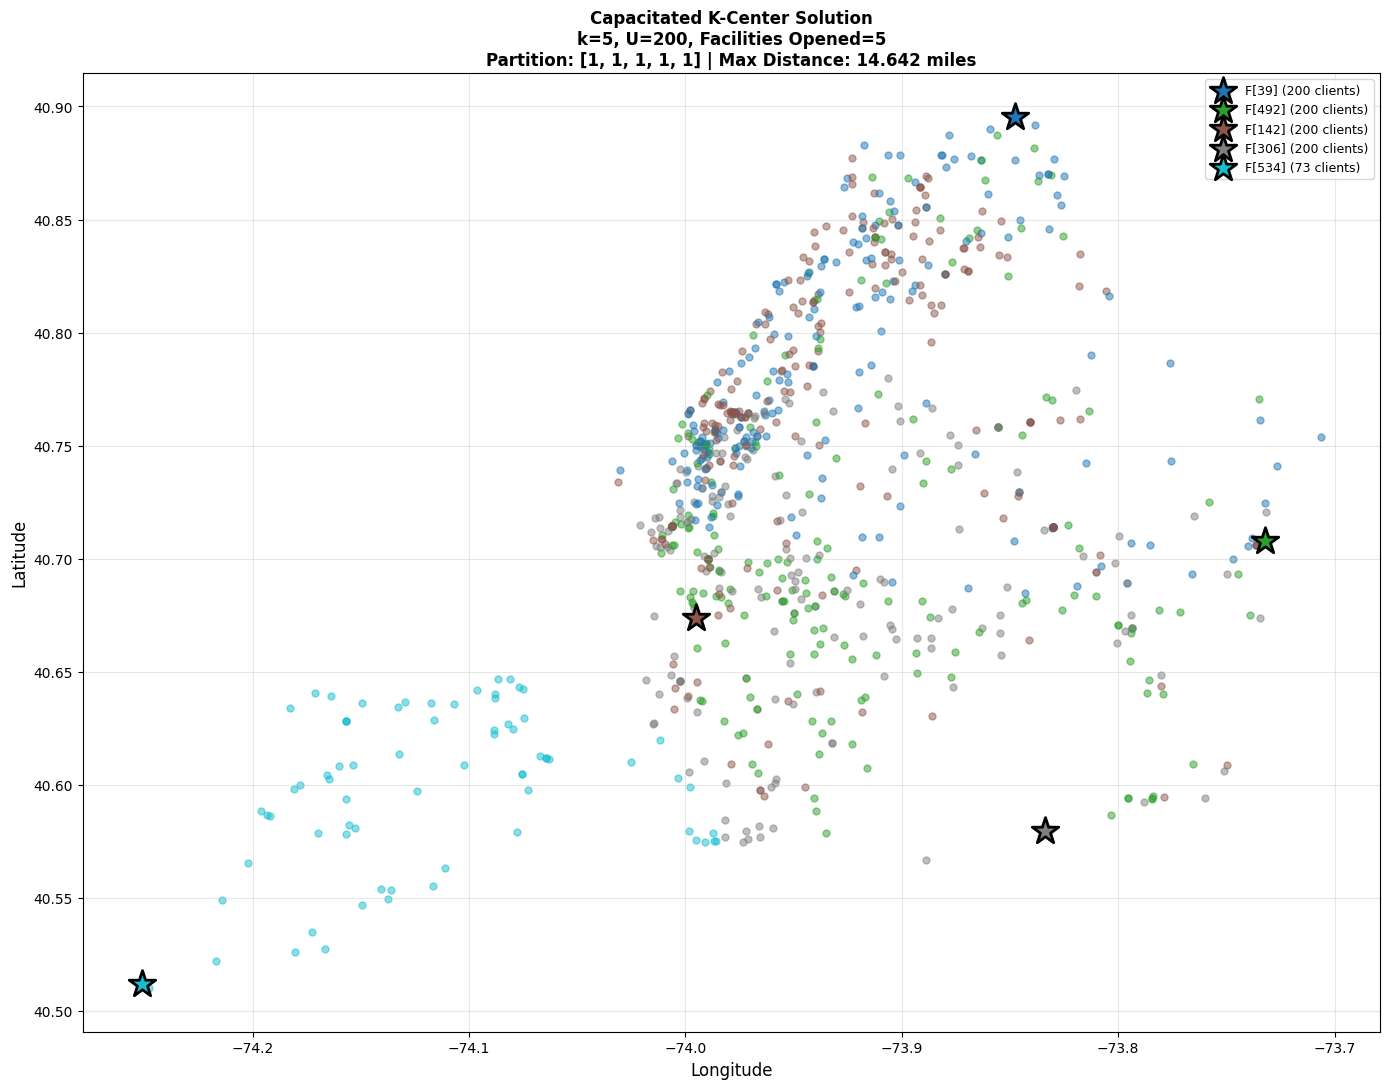


🔗 Slot → Facility Mapping (from Line 16):
   This shows which actual facility each slot represents:
   slot_0_0 → F[142] at (40.6735, -73.9952)
   slot_1_0 → F[534] at (40.5119, -74.2512)
   slot_2_0 → F[39] at (40.8956, -73.8476)
   slot_3_0 → F[492] at (40.7080, -73.7320)
   slot_4_0 → F[306] at (40.5795, -73.8340)


In [ ]:
# =============================================================================
# SECTION 11: VISUALIZATION
# =============================================================================
# This section creates a visual representation of the solution.
#
# PLOT ELEMENTS:
#   - Scatter plot of NYC area
#   - Clients (small dots) colored by their assigned facility
#   - Facilities (large stars) with labels showing load
#   - Legend showing facility IDs and client counts
#
# INTERPRETATION:
#   - Each color represents one facility's "service region"
#   - Stars show where facilities are located
#   - Dense areas indicate high demand regions
# =============================================================================

if solution:
    # -------------------------------------------------------------------------
    # Create figure with appropriate size
    # -------------------------------------------------------------------------
    # figsize=(14, 11) gives enough room for NYC's shape

    fig, ax = plt.subplots(figsize=(14, 11))

    # -------------------------------------------------------------------------
    # Set up colors for each facility
    # -------------------------------------------------------------------------
    # Use tab10 colormap which has 10 distinct colors
    # Each facility gets a unique color for its assigned clients

    num_fac = len(solution['facility_indices'])
    colors = plt.cm.tab10(np.linspace(0, 1, max(num_fac, 1)))

    # Create mapping from facility index to color index
    fac_to_color = {f: i for i, f in enumerate(solution['facility_indices'])}

    # -------------------------------------------------------------------------
    # Plot clients (small dots)
    # -------------------------------------------------------------------------
    # Each client is colored according to its assigned facility
    # This shows the "service regions" created by the solution
    #
    # Note: We plot longitude on x-axis, latitude on y-axis (standard map view)

    for c_idx, f_idx in solution['assignments'].items():
        # Get color for this client's facility
        color_idx = fac_to_color.get(f_idx, 0)

        # Plot client as small dot
        # C[c_idx, 1] = longitude (x-axis)
        # C[c_idx, 0] = latitude (y-axis)
        ax.scatter(
            C[c_idx, 1],          # Longitude (x)
            C[c_idx, 0],          # Latitude (y)
            c=[colors[color_idx]], # Color based on assigned facility
            s=25,                  # Small size for clients
            alpha=0.5              # Semi-transparent for overlaps
        )

    # -------------------------------------------------------------------------
    # Plot facilities (large stars)
    # -------------------------------------------------------------------------
    # Facilities are shown as large stars with black edges
    # Label includes facility index and number of assigned clients

    for i, f_idx in enumerate(solution['facility_indices']):
        # Get load for this facility
        load = solution['facility_loads'].get(f_idx, 0)

        # Plot facility as large star
        ax.scatter(
            F[f_idx, 1],           # Longitude (x)
            F[f_idx, 0],           # Latitude (y)
            c=[colors[i]],         # Same color as its clients
            s=400,                 # Large size for visibility
            marker='*',            # Star shape for facilities
            edgecolors='black',    # Black edge for contrast
            linewidths=2,          # Thick edge
            label=f'F[{f_idx}] ({load} clients)',  # Legend label
            zorder=5               # Draw on top of clients
        )

    # -------------------------------------------------------------------------
    # Configure axes and labels
    # -------------------------------------------------------------------------

    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(
        f'Capacitated K-Center Solution\n'
        f'k={K}, U={CAPACITY}, Facilities Opened={solution["num_facilities"]}\n'
        f'Partition: {solution["partition"]} | Max Distance: {solution["actual_max_distance"]:.3f} miles',
        fontsize=12, fontweight='bold'
    )

    # Add legend showing facility information
    ax.legend(loc='best', fontsize=9)

    # Add grid for easier coordinate reading
    ax.grid(True, alpha=0.3)

    # Adjust layout to prevent label clipping
    plt.tight_layout()

    # Display the plot
    plt.show()

    # -------------------------------------------------------------------------
    # Print slot-to-facility mapping (Line 16 result)
    # -------------------------------------------------------------------------
    # This shows how the abstract "slots" were mapped to actual facilities

    if solution.get('slot_to_facility'):
        print("\n🔗 Slot → Facility Mapping (from Line 16):")
        print("   This shows which actual facility each slot represents:")
        for slot, fac in sorted(solution['slot_to_facility'].items()):
            print(f"   {slot} → F[{fac}] at ({F[fac, 0]:.4f}, {F[fac, 1]:.4f})")

else:
    print("No solution to visualize.")


In [ ]:

if solution:
    print("SOLUTION VERIFICATION")
    print("-"*70)
    print(f"  ✓ Partition used:        {solution['partition']}")
    print(f"  ✓ Total slots created:   {solution['total_slots']} = k")
    print(f"  ✓ Facilities opened:     {solution['num_facilities']} ≤ k")
    print(f"  ✓ Clients assigned:      {len(solution['assignments'])} = |C|")
    print(f"  ✓ Max facility load:     {max(solution['facility_loads'].values())} ≤ U")
    print(f"  ✓ Maximum distance:      {solution['actual_max_distance']:.4f} miles")




SOLUTION VERIFICATION
----------------------------------------------------------------------
  ✓ Partition used:        [1, 0, 2, 1, 1, 1]
  ✓ Total slots created:   6 = k
  ✓ Facilities opened:     6 ≤ k
  ✓ Clients assigned:      873 = |C|
  ✓ Max facility load:     200 ≤ U
  ✓ Maximum distance:      10.6243 miles
